# Wavelet Scattering Transform

In this notebook, we will explore the wavelet scattering transform. This transform is constructed as a convolutional network whose filters are fixed to be wavelet and lowpass averaging filters coupled with modulus nonlinearities, and the resultant transform is invariant to translations and diffeomorphisms, which makes it suitable for CNN-based audio processing. More information regarding the transform can be found [here](https://arxiv.org/pdf/1812.11214.pdf).

First, we'll motivate the need for invariant representations when working with CNNs, especially when acoustic data is involved. The following discussion will justify the use of invariant wavelet scattering transforms, but it also implies that CNNs *might* not be the optimal tool for analyzing acoustic datasets.

## Motivating the Transform

We'll start with some usual imports:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from fastai2.vision.all import *

import librosa
from librosa.display import specshow
import soundfile as sf
import scipy.signal
from kymatio.numpy import Scattering1D
from sklearn.model_selection import train_test_split

import tensorflow as tf

import pathlib
from IPython.display import Audio
import functools
import tqdm
import time
from IPython import display

In [4]:
with tf.device('/GPU:0'):
    print('Running on GPU')
    gpu_test=np.array([1])
    tf_dataset_test = tf.data.Dataset.from_tensor_slices(gpu_test)

Running on GPU


While it is conventional to construct CNNs to carry out spectrogram-based audio ML analysis, I claim that this is not necessarily the right tool for the job. Naively, a spectrogram looks like an image, so it seems to make since to use tools designed for image processing, such as CNNs. However, a spectrogram is fundamentally different from an image, so many of the advantages of CNNs do not apply when working with spectrogram datasets.

For instance, CNNs are purposefully designed to capitalize on invariances that characterize image data. These invariances include (1) rotation, (2) scale, (3) translation, and (4) reflection invariance. What does this mean in practice? Well, let's consider the following image of a Rhodesian ridgeback puppy.

In [5]:
def load_image(img_path):
    from PIL import Image
    img = Image.open(img_path)
    return img

In [6]:
def show_image(img):
    plt.figure(figsize=(6,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

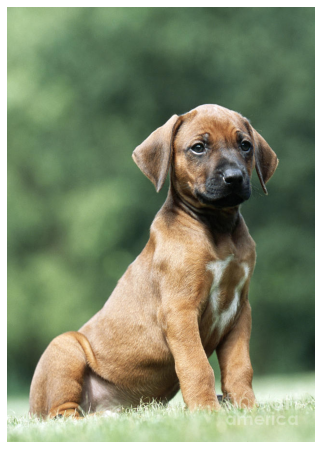

In [8]:
I = load_image('08_Extras/rhodesian_puppy.jpg')
show_image(I)

So cute, right?!? Well, what happens if we rotate the image?

In [9]:
def rotate_image(img, D):
    import scipy.ndimage
    img_D = scipy.ndimage.rotate(img, D, reshape=False)
    return img_D

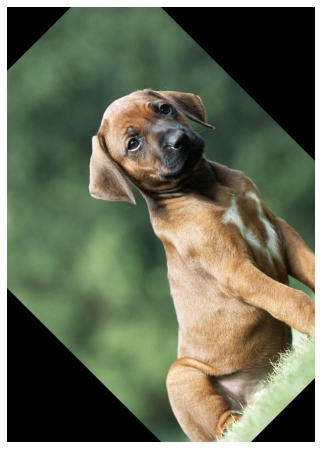

In [10]:
I_45 = rotate_image(I, 45)
show_image(I_45)

Still a cute puppy, right? And if we zoom in?

In [11]:
def zoom_image(img, Nx0, Nx1):
    import scipy.ndimage
    Nx = (Nx0, Nx1, 1)
    img_Nx = scipy.ndimage.zoom(img, Nx)
    dim0 = np.array(img).shape[0]
    dim1 = np.array(img).shape[1]
    cut0 = dim0 - int(dim0 / Nx0)
    cut1 = dim1 - int(dim1 / Nx1)
    img_Nx = img_Nx[cut0:cut0+dim0, cut1:cut1+dim1, :]
    return img_Nx

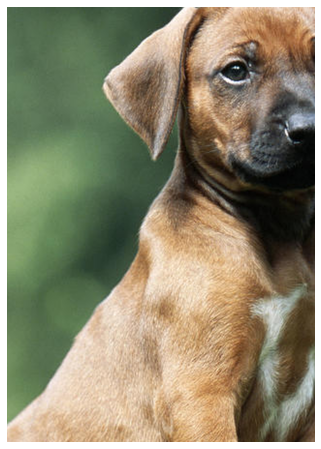

In [12]:
I_2x = zoom_image(I, 2,2)
show_image(I_2x)

Again, clearly a puppy. And if we translate or reflect the image?

In [13]:
def shift_image(img, shift_X, shift_Y):
    import scipy.ndimage
    shift = (shift_Y, shift_X, 0)
    img_shift = scipy.ndimage.shift(img, shift)
    return img_shift

In [14]:
def reflect_image(img, axis='X'):
    from PIL import ImageOps
    if axis == 'X':
        img_ref = ImageOps.mirror(img)
    else:
        img_ref = ImageOps.flip(img)
    return img_ref

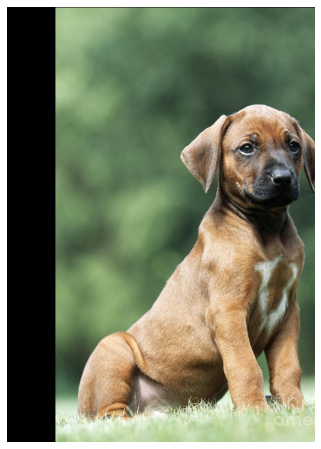

In [15]:
img_100_1 = shift_image(I, 100, 1)
show_image(img_100_1)

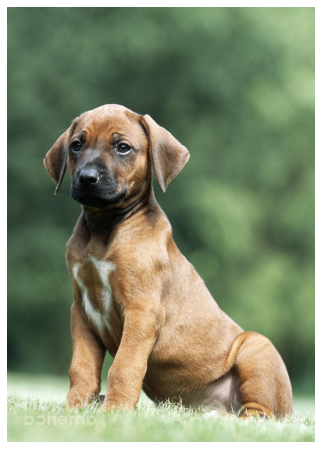

In [16]:
img_mirror = reflect_image(I, 'X')
show_image(img_mirror)

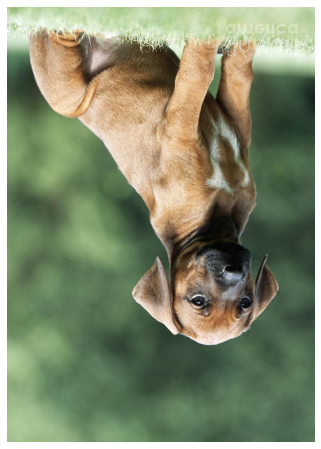

In [17]:
img_flip= reflect_image(I, 'Y')
show_image(img_flip)

Yet again we see the adorable little puppy! This is because image datasets exhibit invariance when performing a number of transformations. CNNs make use of this invariance to carry out classification tasks with a high degree of robustness. This is also why it is possible to use simple transformations to perform data augmentation with image data.

However, these fundamental invariances simply do not apply to audio spectrogram 'image' datasets, primarily due to the inherent meaning of the axes. The x-axis has temporal significance, and the y-axis has spectral significance, so some of the above transformations are not necessarily defined operations when dealing with acoustic data. What does this mean? Let's consider a chirp.

In [18]:
chirp_low_high = librosa.chirp(440, 5440, sr=22050, duration=4)

In [19]:
def generate_spectrogram(signal, sr=22050, low_lim=0, high_lim=22050//2):
    S = librosa.stft(signal)
    return S

In [20]:
def draw_spectrogram(S, title, sr=22050, low_lim=0, high_lim=22050//2):
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(D, y_axis='linear', fmax=sr//2, x_axis='time')
    plt.title(title)
    plt.ylim([low_lim, high_lim])
    plt.colorbar()

In [21]:
def invert_spectrogram(S):
    A = librosa.istft(S)
    return A

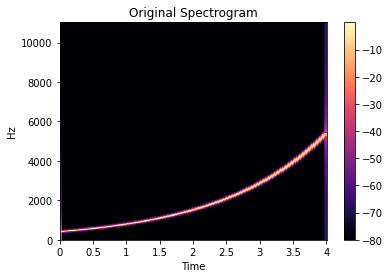

In [22]:
signal = chirp_low_high
S = generate_spectrogram(signal)
draw_spectrogram(S, 'Original Spectrogram')
A = invert_spectrogram(S)
display.Audio(A, rate=22050)

No surprises here! Exactly what we were expecting. What happens if we decide to rotate the spectrogram?

In [23]:
def rotate_spectrogram(S):
    S_90 = np.rot90(S)
    return S_90

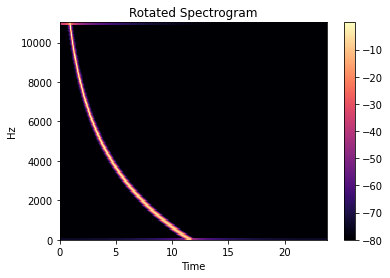

In [24]:
S_90 = rotate_spectrogram(S)
draw_spectrogram(S_90, 'Rotated Spectrogram')
A_90 = invert_spectrogram(S_90)
display.Audio(A_90, rate=22050)

Woah! That is definitely not the same signal. What about if we zoom in?

In [25]:
def zoom_spectrogram(S, Nx0, Nx1):
    import scipy.ndimage
    Nx = (Nx0, Nx1)
    S_Nx = scipy.ndimage.zoom(np.real(S), Nx) + 1j*scipy.ndimage.zoom(np.imag(S), Nx)
    dim0 = S.shape[0]
    dim1 = S.shape[1]
    cut0 = dim0 - int(dim0 / Nx0)
    cut1 = dim1 - int(dim1 / Nx1)
    S_Nx = S_Nx[cut0:cut0+dim0, cut1:cut1+dim1]
    return S_Nx

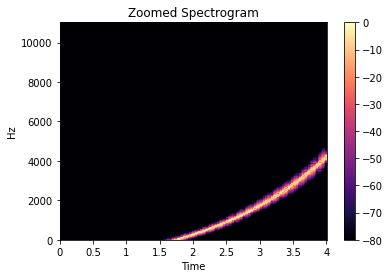

In [29]:
S_12x = zoom_spectrogram(S, 1.2, 1.2)
draw_spectrogram(S_12x, 'Zoomed Spectrogram')
A_12x = invert_spectrogram(S_12x)
display.Audio(A_12x, rate=22050)

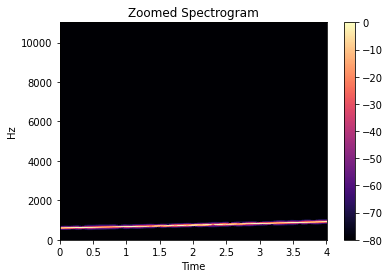

In [28]:
S_1x_6x = zoom_spectrogram(S, 1, 6)
draw_spectrogram(S_1x_6x, 'Zoomed Spectrogram')
A_1x_6x = invert_spectrogram(S_1x_6x)
display.Audio(A_1x_6x, rate=22050)

Geez! Those do not look like the original signal. What about shifts and reflections?

In [30]:
def shift_spectrogram(S, shift_X, shift_Y):
    import scipy.ndimage
    shift = (shift_Y, shift_X)
    S_XY = scipy.ndimage.shift(np.real(S), shift) + 1j*scipy.ndimage.shift(np.imag(S), shift)
    return S_XY

In [31]:
def reflect_spectrogram(S, axis='X'):
    if axis == 'X':
        S_ref = np.fliplr(S)
    else:
        S_ref = np.flipud(S)
    return S_ref

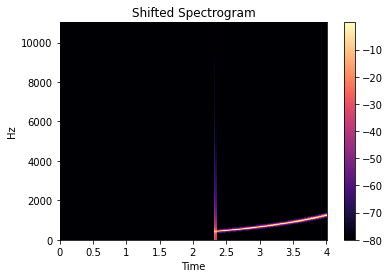

In [32]:
S_100_1 = shift_spectrogram(S, 100, 1)
draw_spectrogram(S_100_1, 'Shifted Spectrogram')
A_100_1 = invert_spectrogram(S_100_1)
display.Audio(A_100_1, rate=22050)

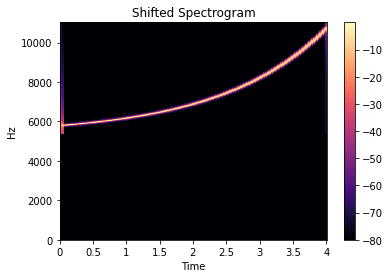

In [33]:
S_1_500 = shift_spectrogram(S, 1, 500)
draw_spectrogram(S_1_500, 'Shifted Spectrogram')
A_1_500 = invert_spectrogram(S_1_500)
display.Audio(A_1_500, rate=22050)

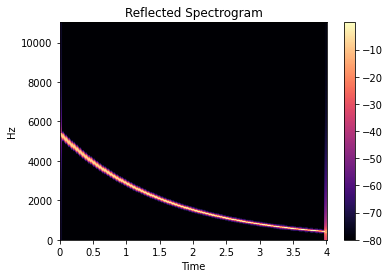

In [34]:
S_mirror = reflect_spectrogram(S, 'X')
draw_spectrogram(S_mirror, 'Reflected Spectrogram')
A_mirror = invert_spectrogram(S_mirror)
display.Audio(A_mirror, rate=22050)

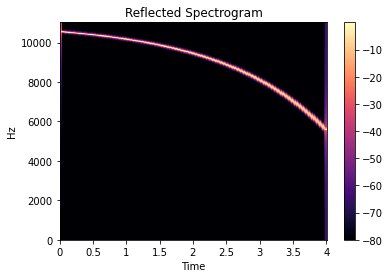

In [36]:
S_flip = reflect_spectrogram(S, 'Y')
draw_spectrogram(S_flip, 'Reflected Spectrogram')
A_flip = invert_spectrogram(S_flip)
display.Audio(A_flip, rate=22050)

And just for fun, the grand finale! What if we combine a bunch of these transformations?

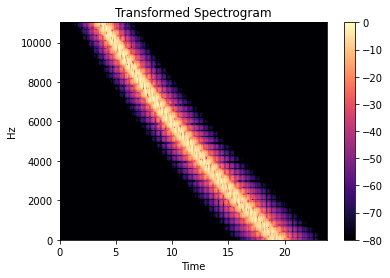

In [37]:
S_transformed = zoom_spectrogram(shift_spectrogram(rotate_spectrogram(S), -10, 1), 5, 5)
draw_spectrogram(S_transformed, 'Transformed Spectrogram')
A_transformed = invert_spectrogram(S_transformed)
display.Audio(A_transformed, rate=22050)

That sounds absolutely nothing like the original signal! What do these results show? For one, they clearly indicate that spectrograms do not behave as images, since they exhibit none of the transformation invariances of image data. In practice, this means that it doesn't necessarily make sense to use CNNs to carry out ML-based analysis of acoustic data. Rather, it might be more appropriate to use RNN-, GRU-, LSTM-, or transformer-based architectures.

An additional indication that the attempt to fit spectrogram 'images' using CNNs might be an invalid approach is that using pretrained ImageNet models often fails to improve performance relative to a simple toy CNN network. Furthermore, when training generative models on spectrogram datasets, using a VGG-based perceptual loss results in perceptually-better-looking spectrograms but yields decreased performance on downstream tasks when compared with the simple L2 reconstruction loss. This might be explained by the fundamental differences between image and spectrogram datasets.

While a CNN might not be the optimal architecture to use, if we are able to generate a representation that is invariant (to some degree) to translation and diffeomorphisms, then it might yield improved results when using CNNs. This leads us to the wavelet scattering transform.

### Addendum: Emordnilap

In case it wasn't instructive enough to use an artificial chirp signal, we can use an example from human speech to show how certain transformations can drastically interfere with the information contained in an acoustic signal. Let's load the signal:

In [42]:
wf, sr = librosa.load('08_Extras/emordnilap.m4a', sr=None)
display.Audio(wf, rate=sr)

/home/peterbermant/.pyenv/versions/3.6.7/envs/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


We hear the word 'Bats'. Let's plot the spectrogram:

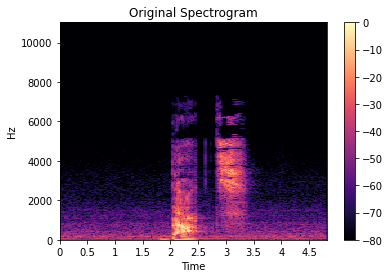

In [43]:
S = generate_spectrogram(wf)
draw_spectrogram(S, 'Original Spectrogram')
A = invert_spectrogram(S)
display.Audio(A, rate=sr)

Ok. Quiz: what happens if we transform this using a reflection about the vertical axis?

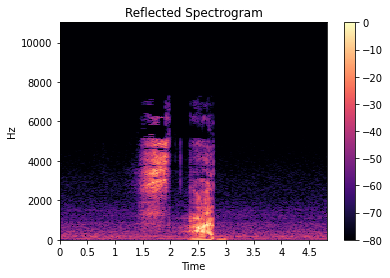

In [44]:
S_mirror = reflect_spectrogram(S, 'X')
draw_spectrogram(S_mirror, 'Reflected Spectrogram')
A_mirror = invert_spectrogram(S_mirror)
display.Audio(A_mirror, rate=sr)

Although it doesn't sound terribly clear, we hear the word 'Stab'. Thus, by carrying out a transformation (reflection) that usually does not significantly impact the meaning of an image, we can drastically alter the information contained in an acoustic signal.

## Exploring the Scattering Wavelet Transform

After having established the need for an invariant transform, we'll take a look at a practical implementation of the scattering wavelet transform using the macaque coo call classification dataset. We've implemented the following code a number of times in previous modules, so we won't dive into it here.

### Loading the Data

In [45]:
SR = 24414
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
FMAX = 7500
DB_TH = 1e-4
MAX = 1
MIN = 0
URL = 'https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip'

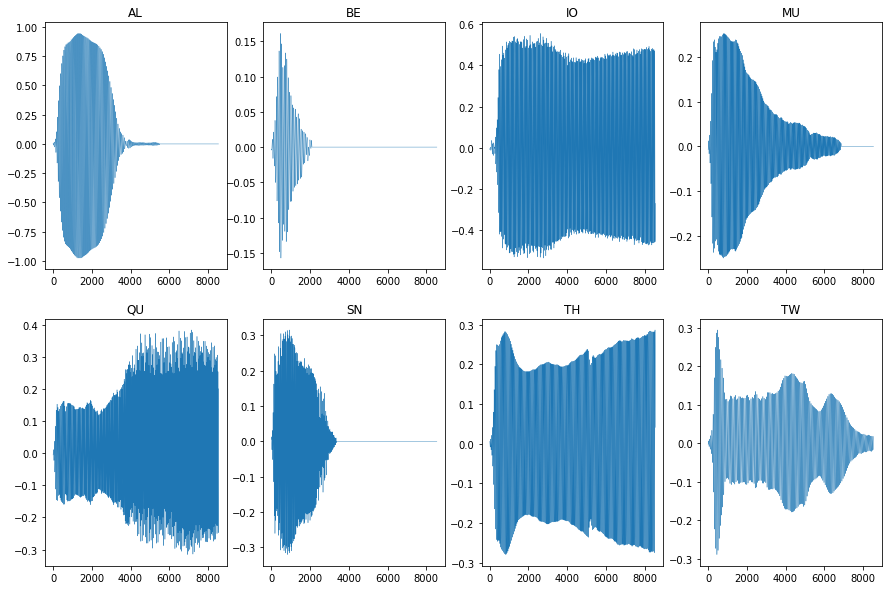

In [5]:
class LoadData(object):
    
    def __init__(self, url=URL):
        self.url = url
        
    def construct_dataframe(self):
        path = untar_data(self.url)
        wav_files = get_files(path)

        wfs = []
        labels = []
        wavs = []

        for wav in wav_files:
            call_code = re.split('/', str(wav))[-2]
            wf, _ = sf.read(wav)

            wfs.append(wf)
            labels.append(call_code)
            wavs.append(wav)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

In [6]:
MEAN_DURATION = mean_dur
WINDOW_WIDTH = MEAN_DURATION

In [7]:
X_numpy = np.zeros((len(data_df), MEAN_DURATION), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X_numpy[i, :] = wf
Y=data_df.Category.values

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2995, 8549), (749, 8549), (2995,), (749,))

### Generating the Representation

With our dataset segmented into training and testing subsets, we can now proceed to generate the scattering wavelet transform representation. First, we'll show an example spectrogram, since we are very familiar with this common acoustic representation.

In [19]:
def show_spectrogram(signal, sr=SR, nfft=NFFT, hoplength=HOP_LENGTH, win=WINDOW, fmax=FMAX):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal, 
                                                    n_fft=nfft,
                                                    hop_length=hoplength,
                                                    window=win)), ref=np.max)
    if fmax is None:
        fmax = sr // 2
        
    librosa.display.specshow(D, y_axis='linear', x_axis='time')
    plt.ylim([0, fmax])
    plt.axis('off')
    plt.show()

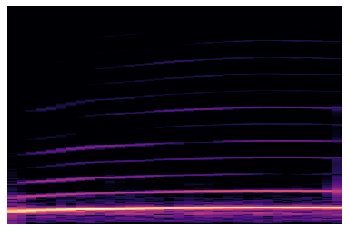

In [21]:
show_spectrogram(X_train[0], fmax=FMAX)

No surprises here! Just our good ol' spectrogram representation which we've seen a number of times already in this toolbox. With this as our baseline, let's move onto to the new material. First, we have to normalize our time series data.

In [22]:
class Normalizer(tf.keras.layers.Layer):
    
    def __init__(self, name='normalizer', **kwargs):
        super(Normalizer, self).__init__(name=name, **kwargs)
        
    def call(self, input_):
        return self.normalize(input_)
        
    @tf.function
    def normalize(self, x):
        batch, samples = x.shape
        _max = tf.math.reduce_max(tf.abs(x), axis=1, keepdims=True, name=None)
        x_norm = x / _max
        return x_norm
         
normalizer = Normalizer()

In [23]:
X_train_norm, X_test_norm = Normalizer()(X_train).numpy(), Normalizer()(X_test).numpy()

Now that we have our normalized input data, we can proceed to carry out a 1D scattering transform. We need to specify four parameters: (1) T is the number of elements in the time series; (2) J (or 2^J) represents the averaging, or maximum, scale, which is essentially the lowest frequencies to be resolved; (3) Q denotes the number of wavelets per octave; and (4) log_eps is an additive constant to prevent the logarithm from blowing up.

In [25]:
T = 8549
J = 6
Q = 16
log_eps = 1e-6

In [26]:
scattering = Scattering1D(J, T, Q)

In [27]:
Sx_train = np.zeros((X_train.shape[0],221,133), dtype='float32')
import tqdm
for i in tqdm.tqdm(range(X_train.shape[0])):
    Sx = scattering(X_train_norm[i]).astype('float32')
    Sx = Sx[1:, :]
    Sx = np.log10(np.abs(Sx) + log_eps)
    Sx_train[i] = Sx

100%|██████████| 2995/2995 [05:31<00:00,  9.05it/s]


In [28]:
Sx_test = np.zeros((X_test.shape[0],221,133), dtype='float32')
import tqdm
for i in tqdm.tqdm(range(X_test.shape[0])):
    Sx = scattering(X_test_norm[i]).astype('float32')
    Sx = Sx[1:, :]
    Sx = np.log10(np.abs(Sx) + log_eps)
    Sx_test[i] = Sx

100%|██████████| 749/749 [01:22<00:00,  9.13it/s]


In [29]:
Sx_train1 = Sx_train[:, 0:63, :]
Sx_train2 = Sx_train[:, 63:, :]
Sx_train1.shape,Sx_train2.shape

((2995, 63, 133), (2995, 158, 133))

Great! Now let's look at the results. We neglect the zeroth-order scattering coefficients, since those represent a low-pass filtered version of the original signal. Instead, we'll focus on the first- and second-order coefficents, which contain most of the acoustic power.

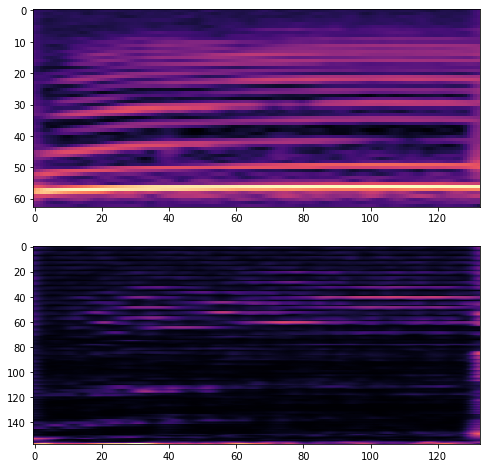

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.imshow(Sx_train1[0], aspect='auto', cmap='magma')
plt.subplot(2, 1, 2)
plt.imshow(Sx_train2[0], aspect='auto', cmap='magma')

### Training a Model

We are now ready to train a model! We'll start off with a multi-head CNN which accepts as inputs the first- and second-order scattering coefficients. The following is very similar to other networks constructed in the toolkit, so again we'll defer further explanation to other modules.

In [51]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [52]:
def build_dual_cnn():
    inputs1 = tf.keras.Input(shape=(63,133))
    x1 = MinMaxScaler(name='minmax1')(inputs1)
    x1 = tf.keras.layers.Reshape((63,133, 1), input_shape=(63,133))(x1)
    x1 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = tf.keras.layers.Dropout(0.25)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    
    inputs2 = tf.keras.Input(shape=(158,133))
    x2 = MinMaxScaler(name='minmax2')(inputs2)
    x2 = tf.keras.layers.Reshape((158,133, 1), input_shape=(158,133))(x2)
    x2 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x2)
    x2 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x2)
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = tf.keras.layers.Dropout(0.25)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
    x2 = tf.keras.layers.Dropout(0.5)(x2)
    
    x = tf.keras.layers.Concatenate()([x1, x2])
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    
    classifier = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name='dual_classifier')
    return classifier

dual_model = build_dual_cnn()
dual_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
dual_model.summary()

Model: "dual_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 63, 133)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 158, 133)]   0                                            
__________________________________________________________________________________________________
minmax1 (MinMaxScaler)          (None, 63, 133)      0           input_1[0][0]                    
__________________________________________________________________________________________________
minmax2 (MinMaxScaler)          (None, 158, 133)     0           input_2[0][0]                    
____________________________________________________________________________________

In [53]:
with tf.device('GPU:0'):
    dual_model.fit([Sx_train1, Sx_train2], Y_train,
              epochs=20,
              batch_size=128,
              validation_split=0.1,
              verbose=1)

Epoch 1/20
22/22 [==============================] - 11s 513ms/step - loss: 0.9713 - accuracy: 0.6709 - val_loss: 0.3220 - val_accuracy: 0.9133
Epoch 2/20
22/22 [==============================] - 10s 449ms/step - loss: 0.2427 - accuracy: 0.9217 - val_loss: 0.2110 - val_accuracy: 0.9367
Epoch 3/20
22/22 [==============================] - 10s 448ms/step - loss: 0.1509 - accuracy: 0.9573 - val_loss: 0.1938 - val_accuracy: 0.9400
Epoch 4/20
22/22 [==============================] - 10s 448ms/step - loss: 0.0744 - accuracy: 0.9759 - val_loss: 0.1776 - val_accuracy: 0.9667
Epoch 5/20
22/22 [==============================] - 10s 448ms/step - loss: 0.0878 - accuracy: 0.9729 - val_loss: 0.1463 - val_accuracy: 0.9667
Epoch 6/20
22/22 [==============================] - 10s 448ms/step - loss: 0.0532 - accuracy: 0.9837 - val_loss: 0.1142 - val_accuracy: 0.9667
Epoch 7/20
22/22 [==============================] - 10s 448ms/step - loss: 0.0417 - accuracy: 0.9859 - val_loss: 0.1074 - val_accuracy: 0.9667

In [55]:
Sx_test1 = Sx_test[:, 0:63, :]
Sx_test2 = Sx_test[:, 63:, :]
Sx_test1.shape,Sx_test2.shape

((749, 63, 133), (749, 158, 133))

In [56]:
dual_model.evaluate([Sx_test1, Sx_test2], Y_test)

24/24 [==============================] - 1s 55ms/step - loss: 0.0118 - accuracy: 0.9920


[0.011752232909202576, 0.9919893145561218]

Wow! Over 99% accuracy on the unseen holdout test set. This indicates that the wavelet scattering transform might be a well-suited representation for carrying out ML-based analysis of bioacoustic data. This concludes our discussion of invariant wavelet scattering transforms. The interested reader is invited to explore the [Kymatio user guide](https://www.kymat.io/userguide.html) for additional information.

## Addendum: Restricting the Analysis to Particular Orders

In the above model, we focused on a rather complicated multi-head topology. Below, we'll explore the possibility of achieving similar results using a more simple architecture. First, we'll plot a few scattergrams to try to build intuition.

In [35]:
def show_scattergram(index, T=8549, J=6, Q=16, log_eps=1e-6):   
    x = X_train[index]

    scattering = Scattering1D(J, T, Q)
    Sx = scattering(x)
    Sx = np.log10(np.abs(Sx) + log_eps)
    
    meta = scattering.meta()
    order0 = np.where(meta['order'] == 0)
    order1 = np.where(meta['order'] == 1)
    order2 = np.where(meta['order'] == 2)

    Sx0 = Sx[order0]
    Sx1 = Sx[order1]
    Sx2 = Sx[order2]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.imshow(Sx1, aspect='auto', cmap='magma')
    plt.subplot(2, 1, 2)
    plt.imshow(Sx2, aspect='auto', cmap='magma')
    plt.show()

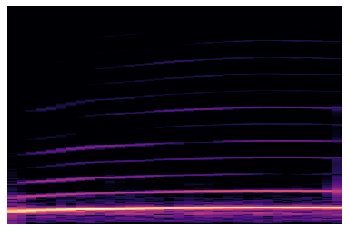

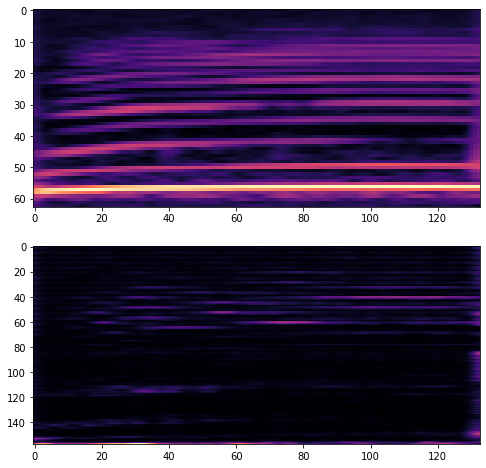

In [37]:
show_spectrogram(X_train[0])
show_scattergram(0)

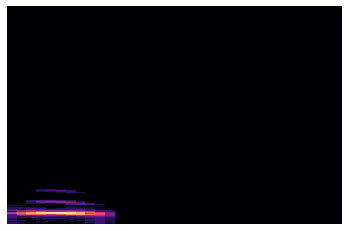

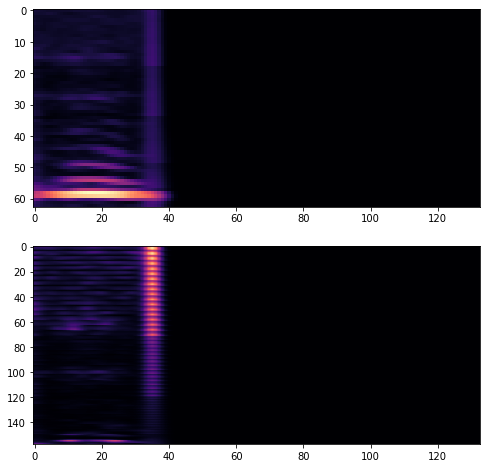

In [38]:
show_spectrogram(X_train[1])
show_scattergram(1)

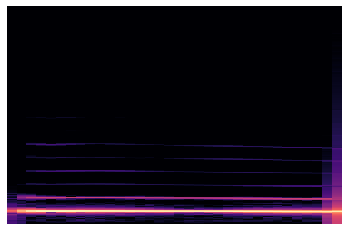

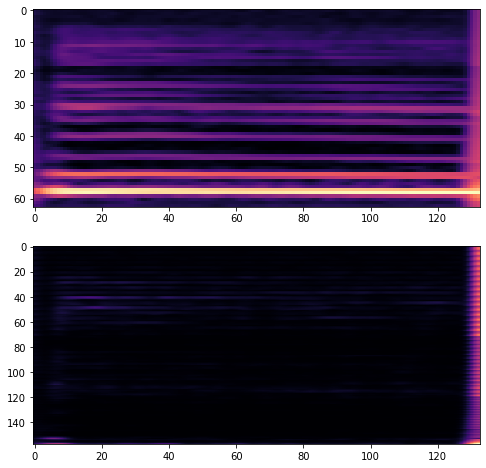

In [39]:
show_spectrogram(X_train[2])
show_scattergram(2)

Next, we'll construct a CNN-based architecture designed for classifying first-order coefficients.

In [94]:
def build_firstorder_cnn():
    inputs1 = tf.keras.Input(shape=(63,133))
    x1 = MinMaxScaler(name='minmax1')(inputs1)
    x1 = tf.keras.layers.Reshape((63,133, 1), input_shape=(63,133))(x1)
    x1 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = tf.keras.layers.Dropout(0.25)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x1)
    
    classifier = tf.keras.Model(inputs=inputs1, outputs=outputs, name='dual_classifier')
    return classifier

order1_model = build_firstorder_cnn()
order1_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
order1_model.summary()

Model: "dual_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 63, 133)]         0         
_________________________________________________________________
minmax1 (MinMaxScaler)       (None, 63, 133)           0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 63, 133, 1)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 61, 131, 32)       320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 59, 129, 64)       18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 29, 64, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 29, 64, 64)    

In [96]:
with tf.device('GPU:0'):
    order1_model.fit(Sx_train1, Y_train,
              epochs=20,
              batch_size=128,
              validation_split=0.1,
              verbose=1)

Epoch 1/20
22/22 [==============================] - 3s 133ms/step - loss: 1.1729 - accuracy: 0.6330 - val_loss: 0.3927 - val_accuracy: 0.8700
Epoch 2/20
22/22 [==============================] - 3s 125ms/step - loss: 0.2906 - accuracy: 0.9176 - val_loss: 0.2273 - val_accuracy: 0.9367
Epoch 3/20
22/22 [==============================] - 3s 124ms/step - loss: 0.1584 - accuracy: 0.9532 - val_loss: 0.1723 - val_accuracy: 0.9500
Epoch 4/20
22/22 [==============================] - 3s 125ms/step - loss: 0.1343 - accuracy: 0.9577 - val_loss: 0.1681 - val_accuracy: 0.9567
Epoch 5/20
22/22 [==============================] - 3s 124ms/step - loss: 0.0794 - accuracy: 0.9785 - val_loss: 0.1389 - val_accuracy: 0.9700
Epoch 6/20
22/22 [==============================] - 3s 124ms/step - loss: 0.0550 - accuracy: 0.9829 - val_loss: 0.1111 - val_accuracy: 0.9767
Epoch 7/20
22/22 [==============================] - 3s 125ms/step - loss: 0.0396 - accuracy: 0.9889 - val_loss: 0.1053 - val_accuracy: 0.9767
Epoch 

In [97]:
order1_model.evaluate(Sx_test1, Y_test)

24/24 [==============================] - 0s 17ms/step - loss: 0.0121 - accuracy: 0.9973


[0.012121196836233139, 0.9973297715187073]

Gee whiz! Our model yields incredibly high test accuracy, suggesting that first-order coefficients suffice for carrying out the analyis. Let's repeat this experiment with second-order scattering coefficients.

In [100]:
def build_secondorder_cnn():
    inputs1 = tf.keras.Input(shape=(158,133))
    x1 = MinMaxScaler(name='minmax1')(inputs1)
    x1 = tf.keras.layers.Reshape((158,133, 1), input_shape=(158,133))(x1)
    x1 = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x1)
    x1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = tf.keras.layers.Dropout(0.25)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(128, activation='relu')(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x1)
    
    classifier = tf.keras.Model(inputs=inputs1, outputs=outputs, name='dual_classifier')
    return classifier

order2_model = build_secondorder_cnn()
order2_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
order2_model.summary()

Model: "dual_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 158, 133)]        0         
_________________________________________________________________
minmax1 (MinMaxScaler)       (None, 158, 133)          0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 158, 133, 1)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 156, 131, 32)      320       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 154, 129, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 77, 64, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 77, 64, 64)    

In [101]:
with tf.device('GPU:0'):
    order2_model.fit(Sx_train2, Y_train,
              epochs=20,
              batch_size=128,
              validation_split=0.1,
              verbose=1)

Epoch 1/20
22/22 [==============================] - 7s 335ms/step - loss: 0.9681 - accuracy: 0.6935 - val_loss: 0.2946 - val_accuracy: 0.9400
Epoch 2/20
22/22 [==============================] - 7s 329ms/step - loss: 0.2483 - accuracy: 0.9273 - val_loss: 0.2125 - val_accuracy: 0.9500
Epoch 3/20
22/22 [==============================] - 7s 329ms/step - loss: 0.1303 - accuracy: 0.9629 - val_loss: 0.1677 - val_accuracy: 0.9533
Epoch 4/20
22/22 [==============================] - 7s 330ms/step - loss: 0.0691 - accuracy: 0.9766 - val_loss: 0.1292 - val_accuracy: 0.9533
Epoch 5/20
22/22 [==============================] - 7s 329ms/step - loss: 0.1280 - accuracy: 0.9607 - val_loss: 0.1704 - val_accuracy: 0.9467
Epoch 6/20
22/22 [==============================] - 7s 328ms/step - loss: 0.0779 - accuracy: 0.9770 - val_loss: 0.1183 - val_accuracy: 0.9633
Epoch 7/20
22/22 [==============================] - 7s 329ms/step - loss: 0.0448 - accuracy: 0.9863 - val_loss: 0.1051 - val_accuracy: 0.9667
Epoch 

In [102]:
order2_model.evaluate(Sx_test2, Y_test)

24/24 [==============================] - 1s 36ms/step - loss: 0.0213 - accuracy: 0.9920


[0.021337728947401047, 0.9919893145561218]

Again we obtain high accuracies, but it seems that including higher order coefficients doesn't improve classification results.